# Agentic Interview Prep

1) Explore the data

2) Come up with:

- Random baseline

- Trivial baseline

3) Start with a simple neural network skelaton to sanity check

4) Overfit

5) Regulerize 


In [1]:
import numpy as np
import torch as th
import torchvision
import torchvision.transforms as transforms

In [1]:
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset

### Get The Data

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(".", train=True, download=True, transform = transforms.Compose([
        transforms.ToTensor()                            
    ]))
test_dataset = torchvision.datasets.FashionMNIST(".", train=False, download=True, transform = transforms.Compose([
        transforms.ToTensor()                               
    ]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw

Processing...
Done!


C:\Users\batua\anaconda3\envs\rlnav2\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Datavis

In [4]:
x_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy(), 
x_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy(), 

In [5]:
print(f"The shapes of the train is:{x_train.shape}, test is {x_test.shape} ")

The shapes of the train is:(60000, 28, 28), test is (10000, 28, 28) 


Text(0.5, 1.0, 'Test')

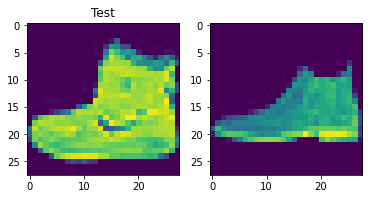

In [6]:
fig, (left_ax, right_ax) = plt.subplots(1,2)
left_ax.imshow(x_train[0])
left_ax.set_title("Train")

right_ax.imshow(x_test[0])
left_ax.set_title("Test")

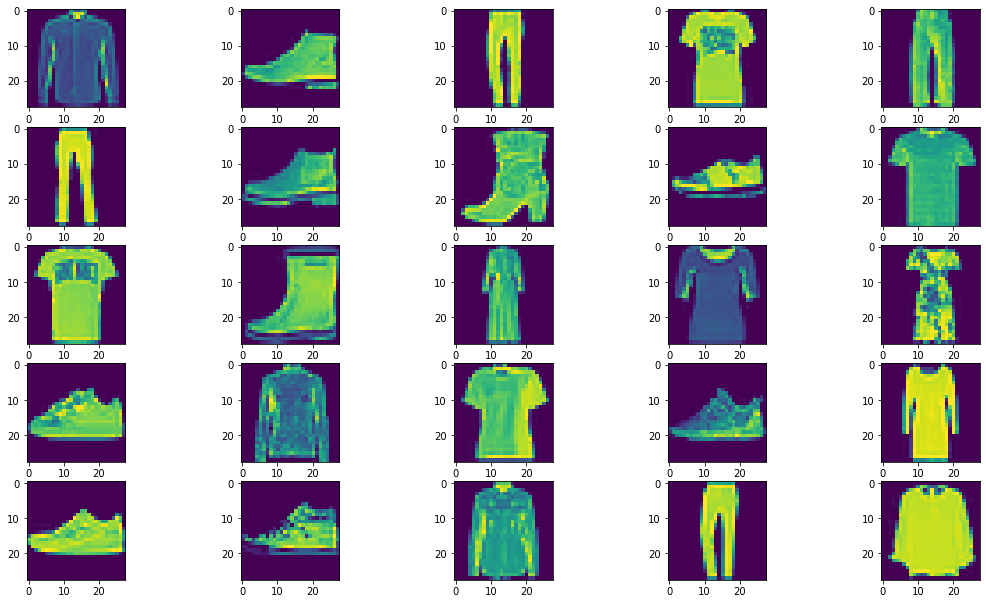

In [7]:
fig, axes = plt.subplots(5,5)
fig.set_size_inches(18.5, 10.5)
for ax in axes.flatten():
    ax.imshow(random.choice(x_train))

The max 255
The min 0
The mean 72.94035223214286
The std 90.02118235130519


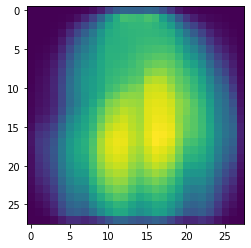

In [8]:
print("The max", np.max(x_train))
print("The min", np.min(x_train))
print("The mean", np.mean(x_train))
print("The std", np.std(x_train))

plt.imshow(np.mean(x_train, axis=0))

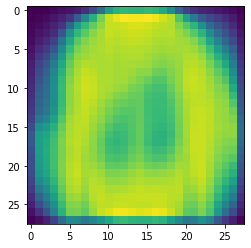

In [9]:
plt.imshow(np.std(x_train, axis=0))

## Baselines

In [10]:
random_baseline_accuracy = .1

In [11]:
class_masks = {}
for cls in range(10):
    class_masks[cls] = y_train == cls

In [12]:
class_means = []
for cls, mask in class_masks.items():
    means = np.mean(x_train[mask])
    print(f"Class {cls}", means)
    class_means.append(means)
class_means = np.array(class_means)

Class 0 83.02998044217686
Class 1 56.84085522959184
Class 2 96.058762542517
Class 3 66.01890858843538
Class 4 98.25800552721088
Class 5 34.86754655612245
Class 6 84.60511989795918
Class 7 42.76207227891157
Class 8 90.15715284863946
Class 9 76.80511840986395


In [13]:
dataset_size = 60000
success_count = 0
for x, y in zip(x_train[:dataset_size], y_train[:dataset_size]):
    img_mean = np.mean(x)
    idx = (np.abs(class_means - img_mean)).argmin()
    if y == idx:
        success_count += 1
success_count / dataset_size

0.24538333333333334

##### Random baseline: 10%
##### Trivial baseline: 24.5% 

## Load the data

In [14]:
batch_size = 32 
train_dataset, valid_dataset = th.utils.data.random_split(train_dataset, [55000, 5000])

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False, num_workers=4)

### Simple network

In [16]:
import pytorch_lightning as pl
import torchmetrics

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from pytorch_lightning.loggers import WandbLogger
import wandb

In [17]:
class CNNLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
                
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        return optimizer
        
    def forward(self, t):  
        # conv 1  
        t = self.conv1(t)  
        t = F.relu(t)  
        t = F.max_pool2d(t, kernel_size=2, stride=2)  
        
        # conv 2  
        t = self.conv2(t)   
        t = F.relu(t)  
        t = F.max_pool2d(t, kernel_size=2, stride=2)   
        
        # fc1   
        t = t.reshape(-1, 12*4*4)  
        t = self.fc1(t)  
        t = F.relu(t)   
        
        # fc2  
        t = self.fc2(t)  
        t = F.relu(t)  
        
        # output  
        t = self.out(t)  

        return t
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        train_acc = self.accuracy(logits, y)
        self.log("train_acc", train_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return {"loss":loss, "train_acc":train_acc}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        logits = self(x)
        val_loss = self.criterion(logits, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        
        val_acc = self.accuracy(logits, y)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    

In [18]:
model = CNNLightning()

### Overfitting to one batch

In [19]:
singlebatch_x, singlebatch_y = next(iter(train_dataloader))
optimizer = optim.Adam(model.parameters(), lr=0.003)
cross_entropy = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy()

In [20]:
for step in range(1001):
    logits = model(singlebatch_x)
    
    loss = cross_entropy(logits, singlebatch_y)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

    accuracy = metric(logits, singlebatch_y)
    
    if step % 100 == 0:
        print(f"Step {step} Loss: {loss.item():.5f} and Accuracy: {accuracy}")    

Step 0 Loss: 2.31226 and Accuracy: 0.1875
Step 100 Loss: 0.00418 and Accuracy: 1.0
Step 200 Loss: 0.00033 and Accuracy: 1.0
Step 300 Loss: 0.00014 and Accuracy: 1.0
Step 400 Loss: 0.00008 and Accuracy: 1.0
Step 500 Loss: 0.00006 and Accuracy: 1.0
Step 600 Loss: 0.00004 and Accuracy: 1.0
Step 700 Loss: 0.00003 and Accuracy: 1.0
Step 800 Loss: 0.00002 and Accuracy: 1.0
Step 900 Loss: 0.00001 and Accuracy: 1.0
Step 1000 Loss: 0.00001 and Accuracy: 1.0


### Train Neural Network

In [21]:
model = CNNLightning()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
cross_entropy = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy()

all_train_losses = []
all_val_losses = []

In [22]:
num_epochs = 5

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_val_losses = []

    accuracies = []
    val_accuracies = []

    model.train()
    print(f"----- Epoch {epoch} -------")
    for batch, train_batch in enumerate(train_dataloader):
        x, y = train_batch
        
        logits = model(x)
        loss = cross_entropy(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc = metric(logits, y)
        
        epoch_losses.append(loss.item())
        accuracies.append(train_acc.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")
        
    model.eval()
    with th.set_grad_enabled(False):
        for step, val_batch in enumerate(valid_dataloader):
            x_val, y_val = val_batch

            logits = model(x_val)
            val_loss = cross_entropy(logits, y_val)
            val_acc = metric(logits, y_val)
            
            epoch_val_losses.append(val_loss.item())
            val_accuracies.append(val_acc.item())

            
    print(f"Epoch {epoch}: Train loss {th.tensor(epoch_losses).mean():.5f}, Train Acc {th.tensor(accuracies).mean():.5f}")
    print(f"      Val loss {th.tensor(epoch_val_losses).mean():.5f}, Val Acc {th.tensor(val_accuracies).mean():.5f}")   
    
    all_train_losses.append(th.tensor(epoch_losses).mean())
    all_val_losses.append(th.tensor(epoch_val_losses).mean())    

----- Epoch 0 -------
loss: 2.314924  [    0/55000]
loss: 1.432269  [ 3200/55000]
loss: 0.828468  [ 6400/55000]
loss: 0.672955  [ 9600/55000]
loss: 0.960863  [12800/55000]
loss: 0.687066  [16000/55000]
loss: 0.642498  [19200/55000]
loss: 0.854102  [22400/55000]
loss: 0.618438  [25600/55000]
loss: 0.634066  [28800/55000]
loss: 0.577960  [32000/55000]
loss: 0.345867  [35200/55000]
loss: 0.483489  [38400/55000]
loss: 1.082173  [41600/55000]
loss: 0.453895  [44800/55000]
loss: 0.514887  [48000/55000]
loss: 0.498791  [51200/55000]
loss: 0.529374  [54400/55000]
Epoch 0: Train loss 0.80378, Train Acc 0.69760
      Val loss 0.59791, Val Acc 0.77110
----- Epoch 1 -------
loss: 0.623116  [    0/55000]
loss: 0.507884  [ 3200/55000]
loss: 0.486958  [ 6400/55000]
loss: 0.464839  [ 9600/55000]
loss: 0.553948  [12800/55000]
loss: 0.509934  [16000/55000]
loss: 0.369673  [19200/55000]
loss: 0.424294  [22400/55000]
loss: 0.565455  [25600/55000]
loss: 0.456614  [28800/55000]
loss: 0.412483  [32000/55000]

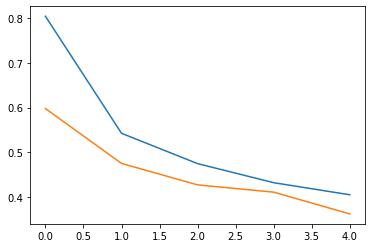

In [23]:
plt.plot(range(len(all_train_losses)), all_train_losses)
plt.plot(range(len(all_val_losses)), all_val_losses)

### Train Neural Network PL

In [24]:
model = CNNLightning()

wandb_logger = WandbLogger(project="AgenticPrep")

trainer = pl.Trainer(gpus=1, max_epochs=5, logger=wandb_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
trainer.fit(model, train_dataloader, val_dataloaders=valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: batu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 156   
1 | conv2     | Conv2d           | 1.8 K 
2 | fc1       | Linear           | 23.2 K
3 | fc2       | Linear           | 7.3 K 
4 | out       | Linear           | 610   
5 | criterion | CrossEntropyLoss | 0     
6 | accuracy  | Accuracy         | 0     
-----------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test

In [26]:
metric = torchmetrics.Accuracy()
accuracies = []
for batch in valid_dataloader:
    x, y = batch
    pred = model(x)
    accuracies.append(metric(y, pred.argmax(dim=1)))

validation_accuracy = np.array(accuracies).mean()
wandb.log({"fin_val_accuracy": validation_accuracy})
print(validation_accuracy)

0.8861465


### Custom Dataset

In [27]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        return
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

NameError: name 'Dataset' is not defined

### Transfer Learning

In [ ]:
import torchvision.models as models

In [ ]:
class CNNTransfer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # init a pretrained resnet
        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify cifar-10 (10 image classes)
        num_target_classes = 10
        self.classifier = nn.Linear(num_filters, num_target_classes)
    
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
                
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        return optimizer
        
    def forward(self, x):  
        self.feature_extractor.eval()
        with th.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)

        return t
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        train_acc = self.accuracy(logits, y)
        self.log("train_acc", train_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return {"loss":loss, "train_acc":train_acc}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        logits = self(x)
        val_loss = self.criterion(logits, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        
        val_acc = self.accuracy(logits, y)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    